In [52]:
# Real life data

import logging
import threading
import itertools
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from mmfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore)
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, r2_score

import scipy as sp
import scipy.fftpack
import skimage as ski

from skimage import util as skiutil # for nifty windowing
import pyod as pyod
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

In [2]:
# setting to make life easier
Temperature='Temperature'
kmeans='TemperatureKmeansScore'
fft='TemperatureFFTScore'
spectral='TemperatureSpectralScore'
sal='SaliencyAnomalyScore'
gen='TemperatureGeneralizedScore'
kmeansA='kmeansAnomaly'
kmeansB='kmeansAnomalyB'
spectralA='spectralAnomaly'
fftA='fftAnomaly'
salA='salAnomaly'
genA='genAnomaly'

kmeans_break=1.3
spectral_break = 2.8
fft_break = 100
sal_break = 100
gen_break = 30000



#### What will be shown

General approach is straightforward
* read raw data in
* transform it so that it is compatible to the Monitoring pipeline
* add yet another anomaly detector based on computer vision technology. The point here is to show how to run pipeline anomaly functions 'locally', an important concept for automated testing.
* simplify the dataframe - we have only one entity, no need for an entity index
* render input data and anomaly scores properly scaled

<br>

We start with Microsoft's anomaly test data found here
https://github.com/microsoft/anomalydetector/blob/master/samples/sample.csv

and then proceed to applying anomaly detection to real life pump data


<br>


#### Current inventory of anomaly detectors by type

This is the list of functions to apply


| Detector | ML Type | Type         | How does it work |
| ------- | ------------ | ------- | ---------------- |
| KMeans | Unsupervised | Proximity | Clusters data points in centroid buckets, small buckets are outliers, score is distance to closest other bucket |
| Generalized | Unsupervised | Linear Model | Covariance matrix over data point vectors serves to measure multi-dimensional deviation |
| FFT | Unsupervised | Linear Model | Run FFT before applying Generalized |
| Spectral | Unsupervised | Linear Model | Compute signal energy to reduce dimensions |
| Saliency | Unsupervised | Linear Model | Apply saliency transform (from computer vision |
| SimpleAnomaly | **Supervised** | Ensemble | Run Gradient boosting on training data, anomaly if prediction deviates from actual data |
| --- | **Supervised** | LSTM | Train a stacked LSTM, anomaly if prediction deviates from actual data |



In [3]:
# Run on the good pump first 
# Get stuff in
df_i = pd.read_csv('./AzureAnomalysample.csv', index_col=False, parse_dates=['timestamp'])

df_i['entity']='MyRoom'
df_i['Temperature']=df_i['value'] + 20
df_i = df_i.drop(columns=['value'])

# and sort it by timestamp
df_i = df_i.sort_values(by='timestamp')
df_i = df_i.set_index(['entity','timestamp']).dropna()

df_i.head(2)

Temperature
entity timestamp                       
MyRoom 2017-10-09 20:32:00         23.0
       2017-10-09 20:33:00         23.0

In [4]:
# Now run the anomaly functions as if they were executed in a pipeline

spsi = SpectralAnomalyScore(Temperature, 12, spectral)
et = spsi._build_entity_type(columns = [Column(Temperature,Float())])
spsi._entity_type = et
df_i = spsi.execute(df=df_i)

sali = SaliencybasedGeneralizedAnomalyScore(Temperature, 12, sal)
et = sali._build_entity_type(columns = [Column(Temperature,Float())])
sali._entity_type = et
df_i = sali.execute(df=df_i)

ffti = FFTbasedGeneralizedAnomalyScore(Temperature, 12, fft)
et = ffti._build_entity_type(columns = [Column(Temperature,Float())])
ffti._entity_type = et
df_i = ffti.execute(df=df_i)

kmi = KMeansAnomalyScore(Temperature, 12, kmeans)
et = kmi._build_entity_type(columns = [Column(Temperature,Float())])
kmi._entity_type = et
df_i = kmi.execute(df=df_i)

df_i.describe()

2020-02-21T11:41:17.143 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-02-21T11:41:17.144 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-02-21T11:41:17.313 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-02-21T11:41:17.314 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-02-21T11:41:18.452 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-02-21T11:41:18.454 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-02-21T11:41:19.760 WARNING iotfunctions.metadat

,Temperature,TemperatureSpectralScore,SaliencyAnomalyScore,TemperatureFFTScore,TemperatureKmeansScore
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,24.264336,0.844163,88.239313,87.483825,0.713396
std,1.484244,0.537002,555.284797,353.660960,1.096254
min,20.000000,0.000064,0.655841,-3.709216,-0.122440
25%,23.062500,0.424042,6.763279,7.965853,0.356834
50%,24.000000,0.787410,15.367436,12.770222,0.461887
75%,25.437500,1.218938,30.400361,18.919044,0.570951
max,30.750000,3.101990,11200.410824,4322.151924,7.327796


In [5]:
# Simplify our pandas dataframe to prepare input for plotting
EngineLogging.configure_console_logging(logging.INFO)

df_inputm2 = df_i.loc[['MyRoom']]
df_inputm2.reset_index(level=[0], inplace=True)

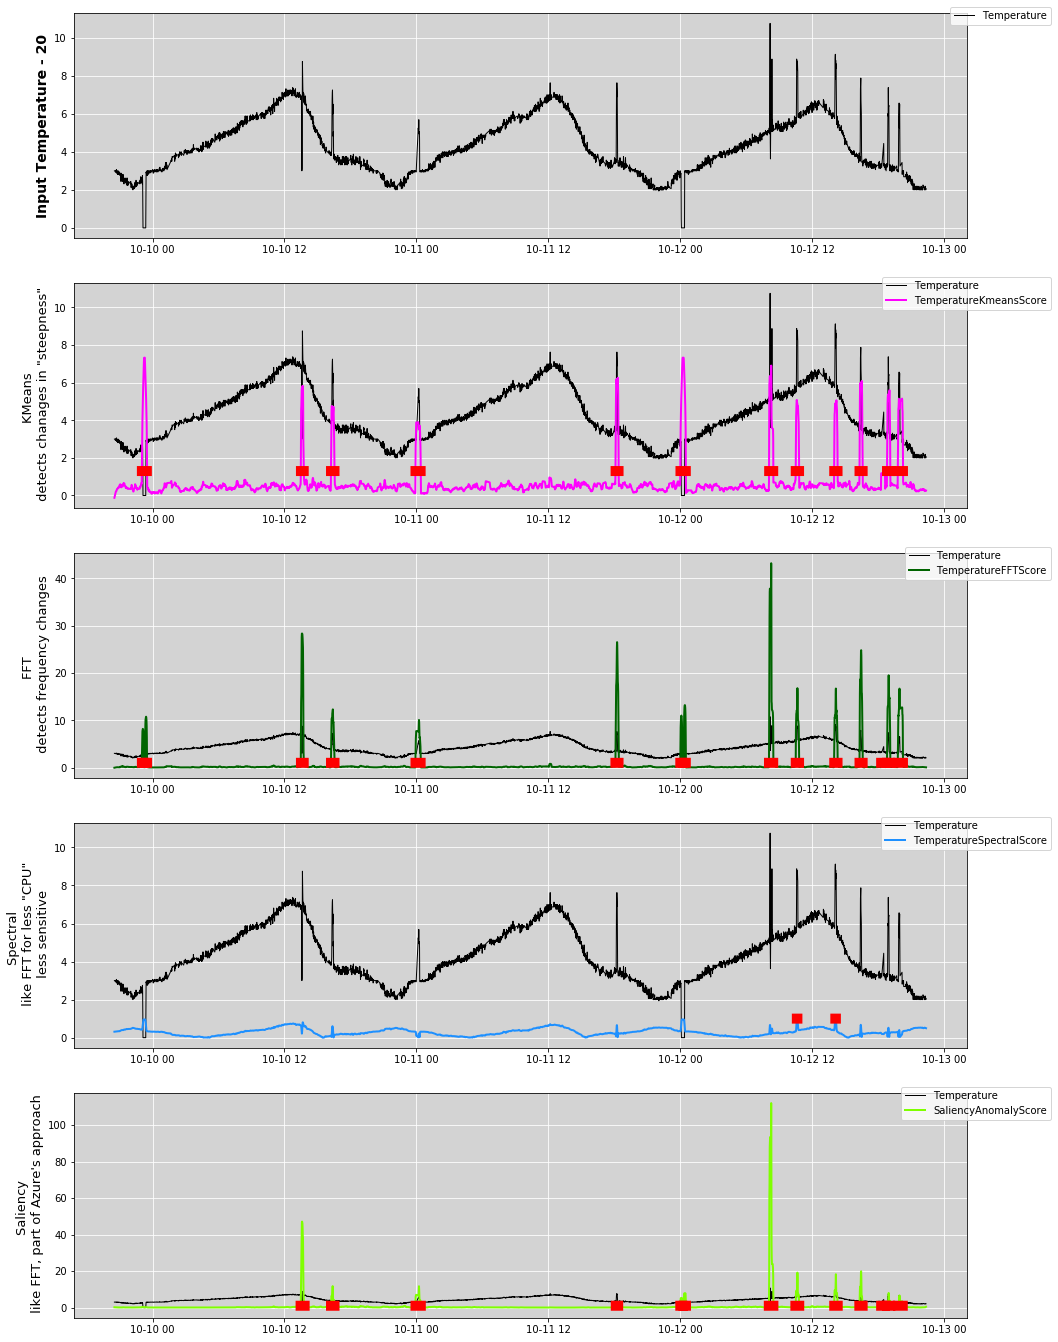

In [6]:
# df_inputm2[spectral].values[df_inputm2[spectral] > 0.001] = 0.001
# df_inputm2[fft].values[df_inputm2[fft] < -1] = -1
df_inputm2[kmeansA] = df_inputm2[kmeans]
df_inputm2[kmeansA].values[df_inputm2[kmeansA] < kmeans_break] = np.nan
df_inputm2[kmeansA].values[df_inputm2[kmeansA] > kmeans_break] = kmeans_break
df_inputm2[kmeansB] = df_inputm2[kmeans]
df_inputm2[kmeansB].values[df_inputm2[kmeansB] >= kmeans_break] = 4
df_inputm2[kmeansB].values[df_inputm2[kmeansB] < kmeans_break] = 3

# Scale spectral and saliency 
# df_inputm2[spectral].values[df_inputm2[spectral] >= spectral_break] = -spectral_break
# df_inputm2[sal].values[df_inputm2[sal] > sal_break] = sal_break



df_inputm2[fftA] = df_inputm2[fft]
df_inputm2[fftA].values[df_inputm2[fftA] < fft_break] = np.nan
df_inputm2[fftA].values[df_inputm2[fftA] > fft_break] = fft_break
df_inputm2[spectralA] = df_inputm2[spectral]
df_inputm2[spectralA].values[df_inputm2[spectralA] < spectral_break] = np.nan
df_inputm2[spectralA].values[df_inputm2[spectralA] > spectral_break] = spectral_break
df_inputm2[salA] = df_inputm2[sal]
df_inputm2[salA].values[df_inputm2[salA] < sal_break] = np.nan
df_inputm2[salA].values[df_inputm2[salA] > sal_break] = sal_break
#df_inputm2[genA] = df_inputm2[gen]
#df_inputm2[genA].values[df_inputm2[genA] < gen_break] = np.nan
#df_inputm2[genA].values[df_inputm2[genA] > gen_break] = gen_break

plots = 5

fig, ax = plt.subplots(plots, 1, figsize=(16,24))
cnt = 0
ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature]-20,linewidth=1,color='black',label=Temperature)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Input Temperature - 20',fontsize=14,weight="bold")
cnt = 1
#ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature]-20,linewidth=1,color='black',label=Input)
#ax[cnt].plot(df_inputm2.index, df_inputm2[kmeans], linewidth=2, color='magenta',label=kmeans)
#ax[cnt].plot(df_inputm2.index, df_inputm2[fft]/fft_break, linewidth=2,color='darkgreen',label=fft)
#ax[cnt].plot(df_inputm2.index, -df_inputm2[spectral]/spectral_break, linewidth=2,color='dodgerblue', label=spectral)
#ax[cnt].plot(df_inputm2.index, df_inputm2[sal]/sal_break, linewidth=2,color='chartreuse',label=sal)
#ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
#ax[cnt].set_ylabel('ALL',fontsize=14,weight="bold")
cnt = 1
ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature]-20,linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputm2.index, df_inputm2[kmeans], linewidth=2, color='magenta',label=kmeans)
ax[cnt].plot(df_inputm2.index, df_inputm2[kmeansA], linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('KMeans \n detects chanages in "steepness"',fontsize=13)
cnt = 2
ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature]-20,linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputm2.index, df_inputm2[fft]/fft_break, linewidth=2,color='darkgreen',label=fft)
ax[cnt].plot(df_inputm2.index, df_inputm2[fftA]/fft_break, linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('FFT \n detects frequency changes', fontsize=13)
cnt = 3
ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature]-20,linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputm2.index, df_inputm2[spectral]/spectral_break, linewidth=2,color='dodgerblue', label=spectral)
ax[cnt].plot(df_inputm2.index, df_inputm2[spectralA]/spectral_break, linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Spectral \n like FFT for less "CPU"\n less sensitive', fontsize=13)
cnt = 4
ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature]-20,linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputm2.index, df_inputm2[sal]/sal_break, linewidth=2,color='chartreuse', label=sal)
ax[cnt].plot(df_inputm2.index, df_inputm2[salA]/sal_break, linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Saliency \n like FFT, part of Azure\'s approach', fontsize=13)

for i in range(plots):
    ax[i].grid(True, color='white')
    ax[i].set_facecolor('lightgrey')

#### Results

Clear **winners** are 
* **KMeans** and 
* **FFT**.

Spectral is way too sensitive while Saliency 
doesn't detect the negative peak at 10/10 midnight


In [7]:
# need a helper function to convert array columns to something easier
from scipy import linalg
def l2norm(df, tcol, col1, col2 = None, col3 = None):
    def str_norm(cols_str):
        '''norm for one string element (encodes an array of value)
           in one column of a data point'''
        return linalg.norm(np.fromstring(cols_str.replace('[',' ').replace(']',''), sep = ','))**2

    def column_norm(df, tcol, col1, col2=None, col3=None):
        '''norm of all columns specified in parameters for all datapoints'''
        df_temp = pd.DataFrame()
        df_temp['col1_np'] = df[col1].apply(str_norm)
        df_temp['col2_np'] = 0 
        df_temp['col3_np'] = 0
        if col2 is not None:
            df_temp['col2_np'] = df[col2].apply(str_norm)
        if col3 is not None:
            df_temp['col3_np'] = df[col3].apply(str_norm)

        return (df_temp['col1_np'] + df_temp['col2_np'] + df_temp['col3_np'])**(1/2)
    
    df[tcol] = column_norm(df, tcol, col1, col2, col3)

def unrollAccel(df):
    l0,l1,l2,l3,l4=[],[],[],[],[]
    for i in df['ACCEL_POWER'].values:
        l0.append(eval(eval(i)[0]))
        l1.append(eval(eval(i)[1]))
        l2.append(eval(eval(i)[2]))
        l3.append(eval(eval(i)[3]))
        l4.append(eval(eval(i)[4]))
    df['accel_power_0'] = np.asarray(l0)
    df['accel_power_1'] = np.asarray(l1)
    df['accel_power_2'] = np.asarray(l2)
    df['accel_power_3'] = np.asarray(l3)
    df['accel_power_4'] = np.asarray(l4)
    
listAttr = ['timestamp','entity','vibrations','rms','accel_speed','accel_power_0','accel_power_1',
            'accel_power_2','accel_power_3','accel_power_4']

In [8]:
# Now we proceed to customer data - GOOD CASE

# Get stuff in
df_input_raw = pd.read_csv('./Armstark04714B6046D5.csv', index_col=False, parse_dates=['RCV_TIMESTAMP_UTC'])
df_input_raw['entity']=df_input_raw['DEVICE_ID']
df_input_raw['timestamp']=df_input_raw['RCV_TIMESTAMP_UTC']

# and sort it by timestamp
df_input_raw = df_input_raw.sort_values(by='timestamp')
df_input_raw = df_input_raw.set_index(['entity','timestamp']).dropna()

l2norm(df_input_raw, 'vibrations', 'VIBRATIONS_XAXIS', 'VIBRATIONS_YAXIS', 'VIBRATIONS_ZAXIS')
l2norm(df_input_raw, 'rms', 'RMS_X', 'RMS_Y', 'RMS_Z')
l2norm(df_input_raw, 'accel_speed', 'ACCEL_SPEED')
unrollAccel(df_input_raw)
#l2norm(df_input_raw, 'accel_power', 'ACCEL_POWER')

df_input = df_input_raw.filter(listAttr, axis=1)
df_input_raw.describe()

/home/markus/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  import sys


,vibrations,rms,accel_speed,accel_power_0,accel_power_1,accel_power_2,accel_power_3,accel_power_4
count,8620.000000,8.620000e+03,8620.0,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000
mean,3.759047,1.732051e+00,1.0,2.453523,2.453312,2.452808,2.452053,2.452439
std,0.033272,4.441150e-16,0.0,0.856247,0.857594,0.857678,0.857200,0.856340
min,3.616515,1.732051e+00,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.737696,1.732051e+00,1.0,2.251800,2.251800,2.252000,2.252000,2.251800
50%,3.757949,1.732051e+00,1.0,2.313800,2.313400,2.311800,2.312200,2.312600
75%,3.780154,1.732051e+00,1.0,2.691450,2.692100,2.685100,2.681850,2.682300
max,3.898555,1.732051e+00,1.0,5.325799,5.293200,5.334001,5.278600,5.282000


In [9]:
# Run Monitoring's anomaly detector functions

salii = SaliencybasedGeneralizedAnomalyScore('vibrations', 12, 'SaliencyVibrationScore')
et = salii._build_entity_type(columns = [Column('vibrations',Float())])
salii._entity_type = et
df_input = salii.execute(df=df_input)


spsii = SpectralAnomalyScore('vibrations', 12, 'SpectralVibrationScore')
et = spsii._build_entity_type(columns = [Column('vibrations',Float())])
spsii._entity_type = et
df_input = spsii.execute(df=df_input)

kmii = KMeansAnomalyScore('vibrations', 12, 'KMeansVibrationScore')
et = kmii._build_entity_type(columns = [Column('vibrations',Float())])
kmii._entity_type = et
df_input = kmii.execute(df=df_input)

fftii = FFTbasedGeneralizedAnomalyScore('vibrations', 12, 'FFTVibrationScore')
et = fftii._build_entity_type(columns = [Column('vibrations',Float())])
fftii._entity_type = et
df_input = fftii.execute(df=df_input)

df_input.describe()

2020-02-21T11:41:23.715 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-02-21T11:41:23.715 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-02-21T11:41:25.476 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-02-21T11:41:25.477 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-02-21T11:41:25.847 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-02-21T11:41:25.848 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-02-21T11:41:27.671 WARNING iotfunctions.metadat

,vibrations,rms,accel_speed,accel_power_0,accel_power_1,accel_power_2,accel_power_3,accel_power_4,SaliencyVibrationScore,SpectralVibrationScore,KMeansVibrationScore,FFTVibrationScore
count,8620.000000,8.620000e+03,8620.0,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000
mean,3.759047,1.732051e+00,1.0,2.453523,2.453312,2.452808,2.452053,2.452439,17.800779,0.796757,0.087910,13.626410
std,0.033272,4.441150e-16,0.0,0.856247,0.857594,0.857678,0.857200,0.856340,14.500460,0.605800,0.025516,7.899178
min,3.616515,1.732051e+00,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.356250,0.000101,0.022206,0.771446
25%,3.737696,1.732051e+00,1.0,2.251800,2.251800,2.252000,2.252000,2.251800,5.836172,0.320830,0.071614,8.418949
50%,3.757949,1.732051e+00,1.0,2.313800,2.313400,2.311800,2.312200,2.312600,14.646424,0.682050,0.085272,12.017815
75%,3.780154,1.732051e+00,1.0,2.691450,2.692100,2.685100,2.681850,2.682300,26.132773,1.132402,0.101605,17.249728
max,3.898555,1.732051e+00,1.0,5.325799,5.293200,5.334001,5.278600,5.282000,98.906003,3.913624,0.214829,63.209517


In [10]:
EngineLogging.configure_console_logging(logging.INFO)

df_input2 = df_input.loc[['04714B6046D5']]
df_input2.reset_index(level=[0], inplace=True)

# redefine
# setting to make life easier
Temperature='vibrations'
kmeans='KMeansVibrationScore'
fft='FFTVibrationScore'
spectral='SpectralVibrationScore'
sal='SaliencyVibrationScore'
#gen='TemperatureGeneralizedScore'
kmeansA='kmeansAnomaly'
kmeansB='kmeansAnomalyB'
spectralA='spectralAnomaly'
fftA='fftAnomaly'
salA='salAnomaly'
genA='genAnomaly'

df_input2

,entity,vibrations,rms,accel_speed,accel_power_0,accel_power_1,accel_power_2,accel_power_3,accel_power_4,SaliencyVibrationScore,SpectralVibrationScore,KMeansVibrationScore,FFTVibrationScore
timestamp,,,,,,,,,,,,,
2020-01-01 00:02:25.928,04714B6046D5,3.787826,1.732051,1.0,2.2904,2.2824,2.2858,2.2956,2.3278,9.993345,0.408917,0.104414,6.748443
2020-01-01 00:07:26.074,04714B6046D5,3.776503,1.732051,1.0,2.2822,2.2978,2.2966,2.3504,2.3190,9.069104,0.380829,0.099605,6.832907
2020-01-01 00:12:25.663,04714B6046D5,3.715573,1.732051,1.0,2.2718,2.2908,2.2912,2.3044,2.3232,8.144863,0.352741,0.094795,6.917370
2020-01-01 00:17:26.020,04714B6046D5,3.765538,1.732051,1.0,2.2748,2.2932,2.2926,2.3146,2.3606,7.220623,0.324653,0.089985,7.001834
2020-01-01 00:22:25.727,04714B6046D5,3.725934,1.732051,1.0,2.3320,2.2980,2.2998,2.3212,2.2860,6.296382,0.296565,0.085176,7.086298
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-31 11:39:23.476,04714B6046D5,3.725156,1.732051,1.0,2.2778,2.2798,2.2676,2.2718,2.2668,7.668004,1.579826,0.107509,16.917500
2020-01-31 11:44:23.497,04714B6046D5,3.766786,1.732051,1.0,2.2734,2.2704,2.2694,2.2728,2.2670,7.305829,1.969820,0.099951,15.033546
2020-01-31 11:49:23.443,04714B6046D5,3.737750,1.732051,1.0,2.2666,2.2714,2.2712,2.2690,2.2646,6.943655,2.359813,0.092393,13.149591


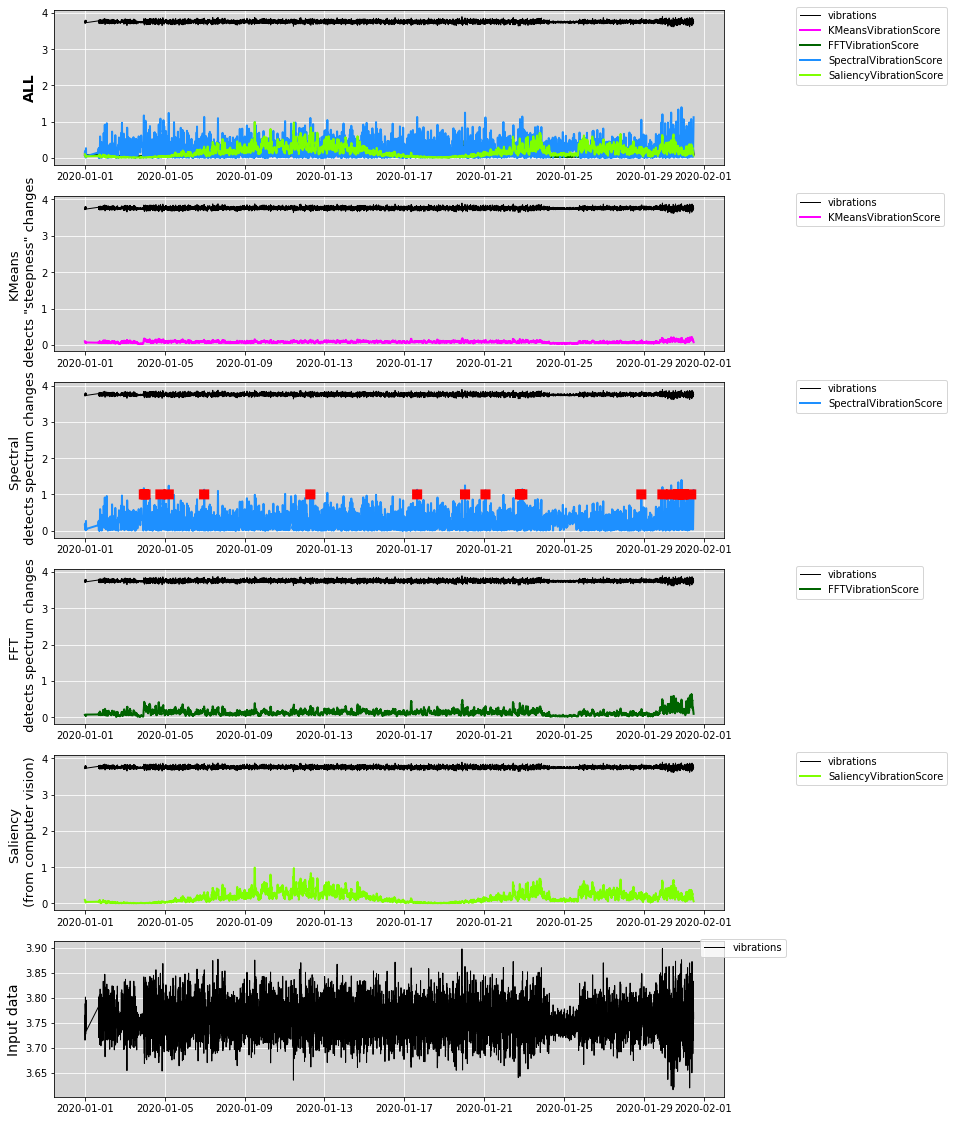

In [11]:
# df_input2[spectral].values[df_input2[spectral] > 0.001] = 0.001
df_input2[fft].values[df_input2[fft] < -1] = -1
df_input2[kmeansA] = df_input2[kmeans]
df_input2[kmeansA].values[df_input2[kmeansA] < kmeans_break] = np.nan
df_input2[kmeansA].values[df_input2[kmeansA] > kmeans_break] = kmeans_break
df_input2[kmeansB] = df_input2[kmeans]
df_input2[kmeansB].values[df_input2[kmeansB] >= kmeans_break] = 4
df_input2[kmeansB].values[df_input2[kmeansB] < kmeans_break] = 3



df_input2[fftA] = df_input2[fft]
df_input2[fftA].values[df_input2[fftA] < fft_break] = np.nan
df_input2[fftA].values[df_input2[fftA] > fft_break] = fft_break
df_input2[spectralA] = df_input2[spectral]
df_input2[spectralA].values[df_input2[spectralA] < spectral_break] = np.nan
df_input2[spectralA].values[df_input2[spectralA] > spectral_break] = spectral_break
df_input2[salA] = df_input2[sal]
df_input2[salA].values[df_input2[salA] < sal_break] = np.nan
df_input2[salA].values[df_input2[salA] > sal_break] = sal_break
#df_input2[genA] = df_input2[gen]
#df_input2[genA].values[df_input2[genA] < gen_break] = np.nan
#df_input2[genA].values[df_input2[genA] > gen_break] = gen_break

plots = 6

fig, ax = plt.subplots(plots, 1, figsize=(12,20))
cnt = 0
ax[cnt].plot(df_input2.index, df_input2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_input2.index, df_input2[kmeans], linewidth=2, color='magenta',label=kmeans)
ax[cnt].plot(df_input2.index, df_input2[fft]/fft_break, linewidth=2,color='darkgreen',label=fft)
ax[cnt].plot(df_input2.index, df_input2[spectral]/spectral_break, linewidth=2,color='dodgerblue', label=spectral)
ax[cnt].plot(df_input2.index, df_input2[sal]/sal_break, linewidth=2,color='chartreuse',label=sal)
#ax[0].plot(df_input2.index, df_input2[gen]/gen_break, linewidth=2,color='darkviolet',label=gen)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('ALL',fontsize=14,weight="bold")
cnt=1
ax[cnt].plot(df_input2.index, df_input2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_input2.index, df_input2[kmeans], linewidth=2, color='magenta',label=kmeans)
#ax[cnt].plot(df_input2.index, df_input2[kmeansB], linewidth=2, color='yellow') #label=kmeans)
ax[cnt].plot(df_input2.index, df_input2[kmeansA], linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('KMeans \n detects "steepness" changes',fontsize=13)
cnt=2
ax[cnt].plot(df_input2.index, df_input2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_input2.index, df_input2[spectral]/spectral_break, linewidth=2,color='dodgerblue', label=spectral)
ax[cnt].plot(df_input2.index, df_input2[spectralA]/spectral_break, linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Spectral \n detects spectrum changes', fontsize=13)
cnt=3
ax[cnt].plot(df_input2.index, df_input2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_input2.index, df_input2[fft]/fft_break, linewidth=2,color='darkgreen',label=fft)
ax[cnt].plot(df_input2.index, df_input2[fftA]/fft_break, linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('FFT \n detects spectrum changes', fontsize=13)
cnt=4
ax[cnt].plot(df_input2.index, df_input2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_input2.index, df_input2[sal]/sal_break, linewidth=2,color='chartreuse', label=sal)
ax[cnt].plot(df_input2.index, df_input2[salA]/sal_break, linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Saliency \n (from computer vision)', fontsize=13)
cnt=5
ax[cnt].plot(df_input2.index, df_input2[Temperature],linewidth=1,color='black',label=Temperature)
#ax[cnt].plot(df_input2.index, df_input2[gen]/gen_break, linewidth=2,color='darkviolet', label=gen)
#ax[cnt].plot(df_input2.index, df_input2[genA]/gen_break, linewidth=10, color='red')
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Input data', fontsize=14)

for i in range(plots):
    ax[i].grid(True, color='white')
    ax[i].set_facecolor('lightgrey')

#ax.set_ylabel('Temperature-50')

In [12]:
# Now we proceed to customer data - BAD CASE

# Get stuff in
df_inputb_raw = pd.read_csv('./Armstark04714B604101.csv', index_col=False, parse_dates=['RCV_TIMESTAMP_UTC'])
df_inputb_raw['entity']=df_inputb_raw['DEVICE_ID']
df_inputb_raw['timestamp']=df_inputb_raw['RCV_TIMESTAMP_UTC']

# and sort it by timestamp
df_inputb_raw = df_inputb_raw.sort_values(by='timestamp')
df_inputb_raw = df_inputb_raw.set_index(['entity','timestamp']).dropna()

l2norm(df_inputb_raw, 'vibrations', 'VIBRATIONS_XAXIS', 'VIBRATIONS_YAXIS', 'VIBRATIONS_ZAXIS')
l2norm(df_inputb_raw, 'rms', 'RMS_X', 'RMS_Y', 'RMS_Z')
l2norm(df_inputb_raw, 'accel_speed', 'ACCEL_SPEED')
unrollAccel(df_inputb_raw)
#l2norm(df_inputb, 'accel_power', 'ACCEL_POWER')

df_inputb = df_inputb_raw.filter(listAttr, axis=1)
df_inputb.head(5)

/home/markus/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  import sys


vibrations       rms  accel_speed  \
entity       timestamp                                                    
04714B604101 2020-01-01 00:02:12.713    3.718562  1.732051          1.0   
             2020-01-01 00:07:12.739    3.786815  1.732051          1.0   
             2020-01-01 00:12:12.769    3.653347  1.732051          1.0   
             2020-01-01 00:17:12.806    3.673086  1.732051          1.0   
             2020-01-01 00:22:13.071    3.754269  1.732051          1.0   

                                      accel_power_0  accel_power_1  \
entity       timestamp                                               
04714B604101 2020-01-01 00:02:12.713         2.3650         2.3388   
             2020-01-01 00:07:12.739         2.5250         2.3846   
             2020-01-01 00:12:12.769         2.5186         2.3766   
             2020-01-01 00:17:12.806         2.4960         2.3822   
             2020-01-01 00:22:13.071         2.5404         2.3874   

                                      accel_power_2  accel_power_3  \
entity       timestamp                                               
04714B604101 2020-01-01 00:02:12.713         2.3410         2.3578   
             2020-01-01 00:07:12.739         2.3978         2.3980   
             2020-01-01 00:12:12.769         2.3606         2.4578   
             2020-01-01 00:17:12.806         2.3832         2.4854   
             2020-01-01 00:22:13.071         2.3896         2.4240   

                                      accel_power_4  
entity       timestamp                               
04714B604101 2020-01-01 00:02:12.713         2.5272  
             2020-01-01 00:07:12.739         2.5762  
             2020-01-01 00:12:12.769         2.5150  
             2020-01-01 00:17:12.806         2.3844  
             2020-01-01 00:22:13.071         2.4112

In [13]:
# Again run Monitoring's anomaly detector functions

salii = SaliencybasedGeneralizedAnomalyScore('vibrations', 12, 'SaliencyVibrationScore')
et = salii._build_entity_type(columns = [Column('vibrations',Float())])
salii._entity_type = et
df_inputb = salii.execute(df=df_inputb)


spsii = SpectralAnomalyScore('vibrations', 12, 'SpectralVibrationScore')
et = spsii._build_entity_type(columns = [Column('vibrations',Float())])
spsii._entity_type = et
df_inputb = spsii.execute(df=df_inputb)

kmii = KMeansAnomalyScore('vibrations', 12, 'KMeansVibrationScore')
et = kmii._build_entity_type(columns = [Column('vibrations',Float())])
kmii._entity_type = et
df_inputb = kmii.execute(df=df_inputb)

fftii = FFTbasedGeneralizedAnomalyScore('vibrations', 12, 'FFTVibrationScore')
et = fftii._build_entity_type(columns = [Column('vibrations',Float())])
fftii._entity_type = et
df_inputb = fftii.execute(df=df_inputb)

df_inputb.describe()

2020-02-21T11:41:32.003 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-02-21T11:41:32.003 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-02-21T11:41:33.778 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-02-21T11:41:33.779 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-02-21T11:41:34.118 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-02-21T11:41:34.119 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-02-21T11:41:35.667 WARNING iotfunctions.metadat

,vibrations,rms,accel_speed,accel_power_0,accel_power_1,accel_power_2,accel_power_3,accel_power_4,SaliencyVibrationScore,SpectralVibrationScore,KMeansVibrationScore,FFTVibrationScore
count,8613.000000,8.613000e+03,8613.0,8613.000000,8613.000000,8613.000000,8613.000000,8613.000000,8613.000000,8613.000000,8613.000000,8613.000000
mean,3.714736,1.732051e+00,1.0,2.408757,2.409634,2.407835,2.408529,2.409018,26.081270,0.781626,0.219516,25.441473
std,0.088517,4.441150e-16,0.0,0.947978,0.948468,0.947572,0.947615,0.947830,29.001247,0.627558,0.107208,24.476679
min,3.299344,1.732051e+00,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.679180,0.000135,0.017232,0.627359
25%,3.664859,1.732051e+00,1.0,2.268600,2.268400,2.268400,2.268000,2.268600,5.915511,0.313840,0.152907,8.724288
50%,3.701923,1.732051e+00,1.0,2.352200,2.351000,2.349600,2.351600,2.352400,15.909103,0.682902,0.197338,15.443427
75%,3.758416,1.732051e+00,1.0,2.666400,2.685000,2.670600,2.671000,2.675600,33.640755,1.033137,0.284931,37.359984
max,4.221860,1.732051e+00,1.0,5.060000,4.975000,4.883400,5.401600,5.238200,225.408455,6.112209,0.674158,155.161242


In [14]:
EngineLogging.configure_console_logging(logging.INFO)

df_inputb2 = df_inputb.loc[['04714B604101']]
df_inputb2.reset_index(level=[0], inplace=True)

# redefine
# setting to make life easier
Temperature='vibrations'
kmeans='KMeansVibrationScore'
fft='FFTVibrationScore'
spectral='SpectralVibrationScore'
sal='SaliencyVibrationScore'
#gen='TemperatureGeneralizedScore'
kmeansA='kmeansAnomaly'
kmeansB='kmeansAnomalyB'
spectralA='spectralAnomaly'
fftA='fftAnomaly'
salA='salAnomaly'
genA='genAnomaly'

df_inputb2

,entity,vibrations,rms,accel_speed,accel_power_0,accel_power_1,accel_power_2,accel_power_3,accel_power_4,SaliencyVibrationScore,SpectralVibrationScore,KMeansVibrationScore,FFTVibrationScore
timestamp,,,,,,,,,,,,,
2020-01-01 00:02:12.713,04714B604101,3.718562,1.732051,1.0,2.3650,2.3388,2.3410,2.3578,2.5272,2.752560,0.151320,0.341451,4.682091
2020-01-01 00:07:12.739,04714B604101,3.786815,1.732051,1.0,2.5250,2.3846,2.3978,2.3980,2.5762,3.217777,0.193383,0.313831,5.745369
2020-01-01 00:12:12.769,04714B604101,3.653347,1.732051,1.0,2.5186,2.3766,2.3606,2.4578,2.5150,3.682993,0.235447,0.286210,6.808646
2020-01-01 00:17:12.806,04714B604101,3.673086,1.732051,1.0,2.4960,2.3822,2.3832,2.4854,2.3844,4.148210,0.277510,0.258590,7.871924
2020-01-01 00:22:13.071,04714B604101,3.754269,1.732051,1.0,2.5404,2.3874,2.3896,2.4240,2.4112,4.613426,0.319574,0.230970,8.935201
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-31 11:36:16.066,04714B604101,3.670139,1.732051,1.0,2.2880,2.2846,2.2898,2.2878,2.2852,16.982708,2.397964,0.335087,58.618973
2020-01-31 11:41:15.841,04714B604101,3.893611,1.732051,1.0,2.2808,2.2876,2.2852,2.2712,2.2704,16.728924,2.881822,0.349217,59.315516
2020-01-31 11:46:16.049,04714B604101,3.660626,1.732051,1.0,2.2820,2.2724,2.2700,2.2682,2.2706,16.475140,3.365680,0.363347,60.012060


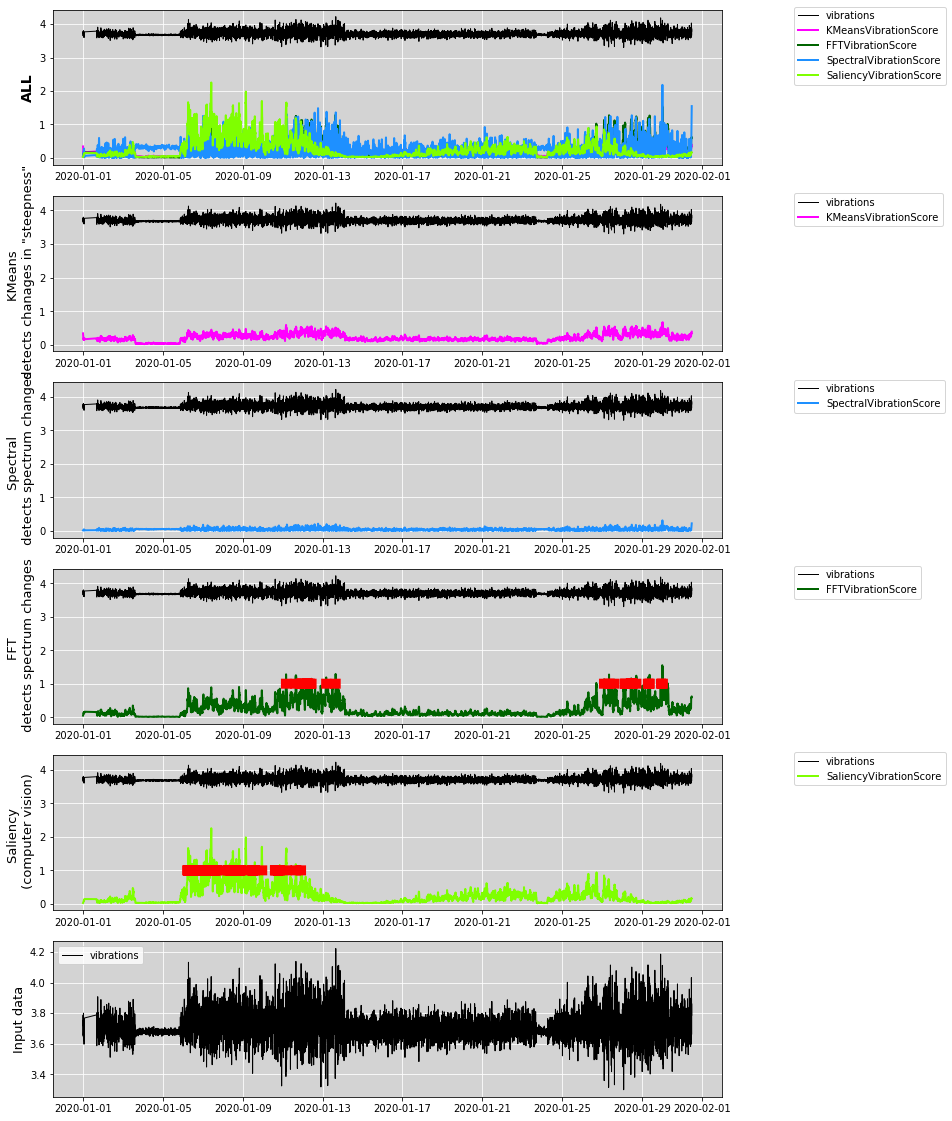

In [15]:
#df_inputb2[spectral].values[df_inputb2[spectral] > 0.001] = 0.001
df_inputb2[fft].values[df_inputb2[fft] < -1] = -1
df_inputb2[kmeansA] = df_inputb2[kmeans]
df_inputb2[kmeansA].values[df_inputb2[kmeansA] < kmeans_break] = np.nan
df_inputb2[kmeansA].values[df_inputb2[kmeansA] > kmeans_break] = kmeans_break
df_inputb2[kmeansB] = df_inputb2[kmeans]
df_inputb2[kmeansB].values[df_inputb2[kmeansB] >= kmeans_break] = 4
df_inputb2[kmeansB].values[df_inputb2[kmeansB] < kmeans_break] = 3



df_inputb2[fftA] = df_inputb2[fft]
df_inputb2[fftA].values[df_inputb2[fftA] < fft_break] = np.nan
df_inputb2[fftA].values[df_inputb2[fftA] > fft_break] = fft_break
df_inputb2[spectralA] = df_inputb2[spectral]
df_inputb2[spectralA].values[df_inputb2[spectralA] < 20] = np.nan
df_inputb2[spectralA].values[df_inputb2[spectralA] > 20] = 20
df_inputb2[salA] = df_inputb2[sal]
df_inputb2[salA].values[df_inputb2[salA] < sal_break] = np.nan
df_inputb2[salA].values[df_inputb2[salA] > sal_break] = sal_break
#df_input2[genA] = df_input2[gen]
#df_input2[genA].values[df_input2[genA] < gen_break] = np.nan
#df_input2[genA].values[df_input2[genA] > gen_break] = gen_break

plots = 6

fig, ax = plt.subplots(plots, 1, figsize=(12,20))
cnt=0
ax[cnt].plot(df_inputb2.index, df_inputb2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputb2.index, df_inputb2[kmeans], linewidth=2, color='magenta',label=kmeans)
ax[cnt].plot(df_inputb2.index, df_inputb2[fft]/fft_break, linewidth=2,color='darkgreen',label=fft)
ax[cnt].plot(df_inputb2.index, df_inputb2[spectral]/spectral_break, linewidth=2,color='dodgerblue', label=spectral)
ax[cnt].plot(df_inputb2.index, df_inputb2[sal]/sal_break, linewidth=2,color='chartreuse',label=sal)
#ax[cnt].plot(df_input2.index, df_input2[gen]/gen_break, linewidth=2,color='darkviolet',label=gen)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('ALL',fontsize=14,weight="bold")
cnt=1
ax[cnt].plot(df_inputb2.index, df_inputb2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputb2.index, df_inputb2[kmeans], linewidth=2, color='magenta',label=kmeans)
ax[cnt].plot(df_inputb2.index, df_inputb2[kmeansA], linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('KMeans \n detects chanages in "steepness"',fontsize=13)
cnt=2
ax[cnt].plot(df_inputb2.index, df_inputb2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputb2.index, df_inputb2[spectral]/20, linewidth=2,color='dodgerblue', label=spectral)
ax[cnt].plot(df_inputb2.index, df_inputb2[spectralA]/20, linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Spectral \n detects spectrum changes', fontsize=13)
cnt=3
ax[cnt].plot(df_inputb2.index, df_inputb2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputb2.index, df_inputb2[fft]/fft_break, linewidth=2,color='darkgreen',label=fft)
ax[cnt].plot(df_inputb2.index, df_inputb2[fftA]/fft_break, linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('FFT \n detects spectrum changes', fontsize=13)
cnt=4
ax[cnt].plot(df_inputb2.index, df_inputb2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputb2.index, df_inputb2[sal]/sal_break, linewidth=2,color='chartreuse', label=sal)
ax[cnt].plot(df_inputb2.index, df_inputb2[salA]/sal_break, linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Saliency \n (computer vision)', fontsize=13)
cnt=5
ax[cnt].plot(df_inputb2.index, df_inputb2[Temperature],linewidth=1,color='black',label=Temperature)
#ax[cnt].plot(df_inputb2.index, df_inputb2[gen]/gen_break, linewidth=2,color='darkviolet', label=gen)
#ax[cnt].plot(df_inputb2.index, df_inputb2[genA]/gen_break, linewidth=10, color='red')
ax[cnt].legend()#bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Input data', fontsize=13)

for i in range(plots):
    ax[i].grid(True, color='white')
    ax[i].set_facecolor('lightgrey')


#ax.set_ylabel('Temperature-50')

In [53]:
# Prepare for evaluating how good we're doing

# before anomaly "negatives"
before_anomaly1 = dt.datetime(2020,1,7,0,0,0)  # before anomaly "negatives"
after_anomaly1 = dt.datetime(2020,1,14,0,0,0)  
before_anomaly2 = dt.datetime(2020,1,27,0,0,0) 
after_anomaly2 = dt.datetime(2020,1,31,0,0,0)

# 'label' anomalies
df_inputb2.loc[df_inputb2.index < before_anomaly1,'actual'] = 0
df_inputb2.loc[(df_inputb2.index > before_anomaly1) &
           (df_inputb2.index < after_anomaly1),'actual'] = 1
df_inputb2.loc[(df_inputb2.index > after_anomaly1) &
           (df_inputb2.index < before_anomaly2),'actual'] = 0
df_inputb2.loc[(df_inputb2.index > before_anomaly2) &
           (df_inputb2.index < after_anomaly2),'actual'] = 1
df_inputb2.loc[(df_inputb2.index > after_anomaly2),'actual'] = 0

yyy_test = df_inputb2['actual'].values

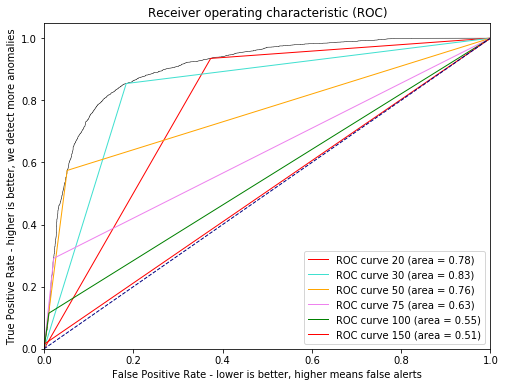

In [54]:
# ROC curve FFT + Saliency

np_range = np.arange(0, 151, 1)
score_list = []
fpr_list = []
tpr_list = []
roc_auc_list = []

for ths in np_range:
    yyy_score_ = (np.greater(df_inputb2[fft], ths) | np.greater(df_inputb2[sal], ths)).astype(int)
    score_list.append(yyy_score_)
    fpr_, tpr_, _ = roc_curve(yyy_test, yyy_score_)
    fpr_list.append(fpr_)
    tpr_list.append(tpr_)
    roc_auc_list.append(auc(fpr_,tpr_))

    
yy_score = np.asarray(score_list)
fpr = np.asarray(fpr_list)
tpr = np.asarray(tpr_list)
roc_auc = np.asarray(roc_auc_list)

yyF_score = np.maximum(df_inputb2[fft].values, df_inputb2[sal].values)
fprF, tprF, _ = roc_curve(yyy_test, yyF_score/200)
roc_aucF = auc(fprF, tprF)


fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(fprF, tprF, color='black', lw=0.5)
ax.plot(fpr[20], tpr[20], color='red',lw=1, label='ROC curve 20 (area = %0.2f)' % roc_auc[20])
ax.plot(fpr[30], tpr[30], color='turquoise',lw=1, label='ROC curve 30 (area = %0.2f)' % roc_auc[30])
ax.plot(fpr[50], tpr[50], color='orange',lw=1, label='ROC curve 50 (area = %0.2f)' % roc_auc[50])
ax.plot(fpr[75], tpr[75], color='violet',lw=1, label='ROC curve 75 (area = %0.2f)' % roc_auc[75])
ax.plot(fpr[100], tpr[100], color='green',lw=1, label='ROC curve 100 (area = %0.2f)' % roc_auc[100])
ax.plot(fpr[150], tpr[150], color='red',lw=1, label='ROC curve 150 (area = %0.2f)' % roc_auc[150])
ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate - lower is better, higher means false alerts')
plt.ylabel('True Positive Rate - higher is better, we detect more anomalies')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


#### Try out supervised methods

* Train a stacked LSTM
* Run gradient boosting


In [158]:
# part of mmfunctions
import telemanom
from telemanom.helpers import Config
from telemanom.errors import Errors
import telemanom.helpers as helpers
from telemanom.channel import Channel
from telemanom.modeling import Model

conf = Config("./telemanom/config.yaml")
list_attr=['vibrations','accel_power_0','accel_power_1','accel_power_2','accel_power_3','accel_power_4']
#list_attr=['vibrations','accel_power_0']
conf.dictionary['l_s'] = 250
conf.dictionary['epochs'] = 80
conf.dictionary['dropout'] = 0.2
conf.l_s = 250
# conf.epochs = 80
conf.dropout = 0.2
conf.lstm_batch_size=80

In [159]:
# scale higher (*2) to make it a bit harder on the training run
tel_input = df_input[list_attr].values
tel_input = (tel_input - tel_input.mean())*3
tel_inputb = df_inputb[list_attr].values
tel_inputb = (tel_inputb - tel_inputb.mean())*3
np.save("telemanom/data/train/Armstarknew.npy", tel_input)
np.save("telemanom/data/test/Armstarknew.npy", tel_inputb)

In [160]:
# Load data from 
device="Armstarknew"
chan = Channel(conf, device)
helpers.make_dirs(conf.use_id, conf, "./telemanom")
print(chan)
print(conf.l_s)


Channel:Channel
250


In [161]:
#chan.delete_data("./telemanom")
chan.load_data("./telemanom")
# chan.train
dfA = pd.DataFrame(chan.train)
dfA.describe()

,0,1,2,3,4,5
count,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000
mean,3.265551,-0.651023,-0.651655,-0.653168,-0.655431,-0.654274
std,0.099815,2.568741,2.572781,2.573033,2.571600,2.569019
min,2.837953,-8.011591,-8.011591,-8.011591,-8.011591,-8.011591
25%,3.201497,-1.256191,-1.256191,-1.255591,-1.255591,-1.256191
50%,3.262258,-1.070191,-1.071391,-1.076191,-1.074991,-1.073791
75%,3.328871,0.062759,0.064709,0.043709,0.033959,0.035309
max,3.684075,7.965806,7.868009,7.990412,7.824209,7.834409


In [162]:
print(chan)


Channel:Channel
Training data shape: (8360, 250, 6), (8360, 10)
  Test data shape: (8353, 250, 6), (8353, 10)
  Original data shape: (8620, 6), (8613, 6)


Text(0.5, 1.0, 'Test (bad) data')

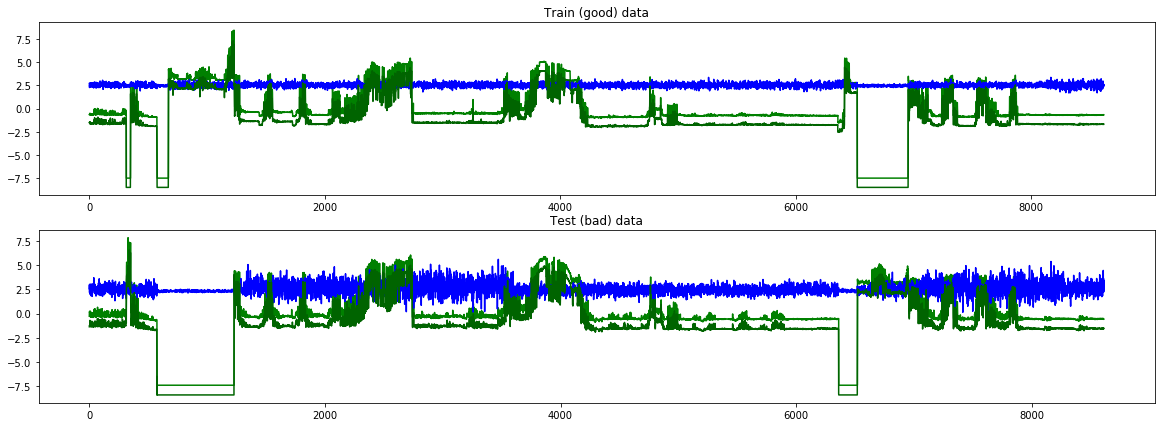

In [163]:
# chan.train
fig, ax = plt.subplots(2, 1, figsize=(20, 7))
ax[0].plot((chan.train[:,0]-2)*2, color='blue')
ax[0].plot(chan.train[:,1]+0.5, color='green',zorder=1)
ax[0].plot(chan.train[:,5]-0.5, color='darkgreen')
ax[0].set_title('Train (good) data')
ax[1].plot((chan.test[:,0]-2)*2, color='blue')
ax[1].plot(chan.test[:,1]+0.5, color='green',zorder=1)
ax[1].plot(chan.test[:,2]-0.5, color='darkgreen')
ax[1].set_title('Test (bad) data')


In [164]:
# producing overlapping windows of length 260 for lookback (250) and prediction (10)
chan.shape_data(chan.train, train=True)

In [165]:
# init the Keras double stacked LSTM model
model = Model(conf, conf.use_id, chan, "./telemanom", False)

In [166]:
# drink a coffee - training takes roughly 7 minutes
model.train_new(chan)

Train on 6688 samples, validate on 1672 samples
Epoch 1/35
6688/6688 [==============================] - 24s 4ms/step - loss: 1.4353 - val_loss: 0.0158
Epoch 2/35
6688/6688 [==============================] - 25s 4ms/step - loss: 0.2127 - val_loss: 0.0113
Epoch 3/35
6688/6688 [==============================] - 25s 4ms/step - loss: 0.1685 - val_loss: 0.0138
Epoch 4/35
6688/6688 [==============================] - 25s 4ms/step - loss: 0.1416 - val_loss: 0.0112
Epoch 5/35
6688/6688 [==============================] - 25s 4ms/step - loss: 0.1227 - val_loss: 0.0120
Epoch 6/35
6688/6688 [==============================] - 24s 4ms/step - loss: 0.1067 - val_loss: 0.0103
Epoch 7/35
6688/6688 [==============================] - 25s 4ms/step - loss: 0.0960 - val_loss: 0.0106
Epoch 8/35
6688/6688 [==============================] - 25s 4ms/step - loss: 0.0871 - val_loss: 0.0135
Epoch 9/35
6688/6688 [==============================] - 24s 4ms/step - loss: 0.0824 - val_loss: 0.0111
Epoch 10/35
6688/6688 [==

#### Training parameters

```
loss_metric: 'mse'    # minimize mean square error
optimizer: 'adam'     # sort of adaptive stochastic gradient descent
validation_split: 0.2 # 20% of the data is used for validating (val_loss)
dropout: 0.3          # ditch 30% of the LSTMs results when minimizing the loss function to avoid overfitting
lstm_batch_size: 64   # number of training data batches to evaluate per optimizer run to update the model’s parameters

patience: 10          # try at least 10 times to decrease val_loss smaller by ...
min_delta: 0.0003     # ... at least min_delta, else stop, so we get at least 'patience' epochs
epochs: 35            # no more than 35 passes through the entier training dataset.

l_s: 250              # lookback: num previous timesteps provided to model to predict future values
n_predictions: 10     # number of steps ahead to predict
```

This is defined in `telemanom/config.yaml`
<br>

In [167]:
# predicting takes roughly 12 secs
model.batch_predict(chan, Path="./telemanom")

In [168]:
# smooth the prediction error and apply exponential weights to it
errors = Errors(chan, conf, conf.use_id, "./telemanom")

#  for each overlapping window establish a threshold so that removing error points above it 
# maximizes the reduction of mean and standard deviation. Sort of an adaptive z-score 
errors.process_batches(chan)

2020-02-21T16:57:11.998 INFO telemanom.__init__ normalized prediction error: 0.07


In [169]:
print (errors.E_seq, " \n ", errors.anom_scores)

[(6340, 6619), (7040, 7529)]  
  [{'start_idx': 6090, 'end_idx': 6159, 'score': 0.6614375613283862}, {'start_idx': 6160, 'end_idx': 6229, 'score': 2.12282112627787}, {'start_idx': 6230, 'end_idx': 6299, 'score': 2.5102316061360734}, {'start_idx': 6300, 'end_idx': 6369, 'score': 2.3380586195620454}, {'start_idx': 6790, 'end_idx': 6859, 'score': 1.043898399350199}, {'start_idx': 6860, 'end_idx': 6929, 'score': 1.2401683332481535}, {'start_idx': 6930, 'end_idx': 6999, 'score': 3.8233416292343154}, {'start_idx': 7000, 'end_idx': 7069, 'score': 3.8509722522593557}, {'start_idx': 7070, 'end_idx': 7139, 'score': 3.7505446012096}, {'start_idx': 7140, 'end_idx': 7209, 'score': 4.079580011011678}, {'start_idx': 7210, 'end_idx': 7279, 'score': 4.179774029051882}]


In [170]:
model.save("./telemanom")

In [171]:
# How good are we doing ?

model.model.evaluate(chan.X_test, chan.y_test)

8353/8353 [==============================] - 11s 1ms/step


0.07274640389130199

In [172]:
#model.batch_predict(chan, Path="./telemanom", Train=True)


Text(0.5, 1.0, 'Vibration Forecast - predicted')

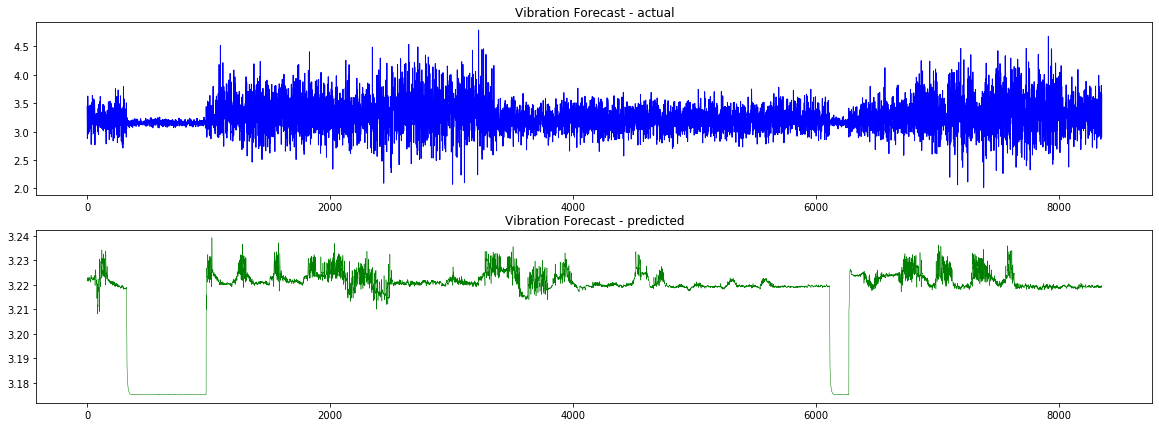

In [185]:
fig, ax = plt.subplots(2, 1, figsize=(20, 7))
#ax[0].plot(chan.y_train_hat[:8200] * 10, lw=0.2, color='green')  # to be done
ax[0].plot(chan.y_test[:,0], lw=1, color='blue', label='vibration')
ax[0].set_title('Vibration Forecast - actual')
ax[1].plot(chan.y_hat, lw=0.5, color='green')
ax[1].set_title('Vibration Forecast - predicted')

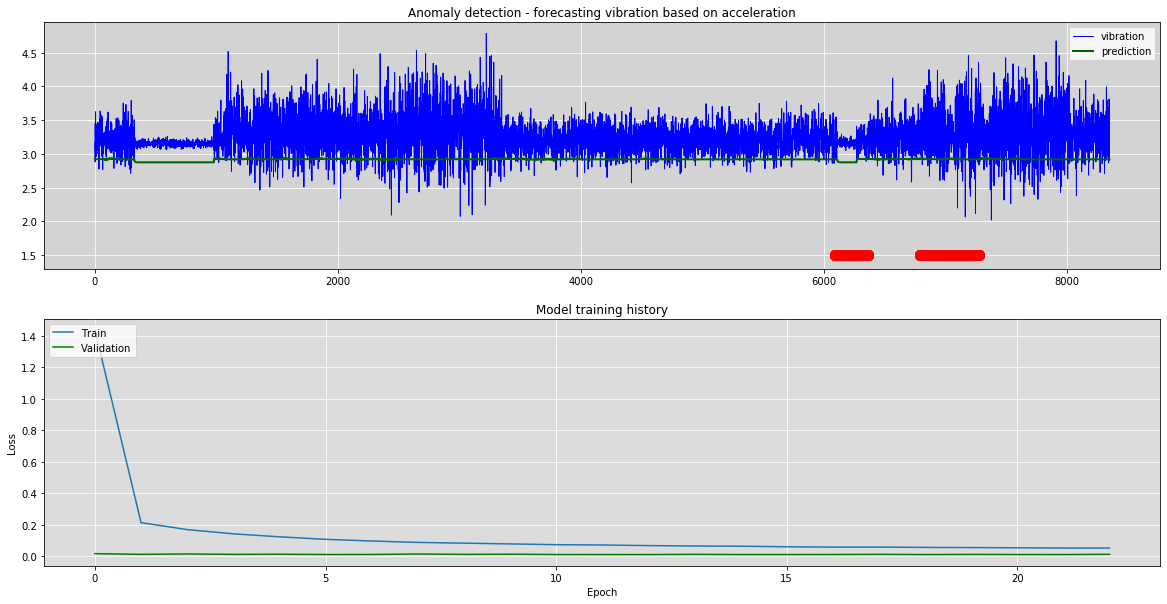

In [181]:
npic = 1
fig, ax = plt.subplots(npic+1, 1, figsize=(20, (npic+1) * 5))
ax[npic-1].set_title('Anomaly detection - forecasting vibration based on acceleration')
ax[npic-1].plot(chan.y_test[:,0], lw=1, color='blue', label='vibration')

#ax.scatter(x_axis, temp_sal_high, lw=8, color='red')
for asc in errors.anom_scores:
    x_axis = np.arange(asc['start_idx'],asc['end_idx'],1)
    y_axis = np.zeros(asc['end_idx'] - asc['start_idx'])
    ax[npic-1].grid(True, color='white')
    ax[npic-1].set_facecolor('lightgrey')
    ax[npic-1].scatter(x_axis,y_axis+1.5, lw=5, color='red', zorder=10)
ax[npic-1].grid(True, color='white')
ax[npic-1].set_facecolor('lightgrey')
#ax[npic-1].plot(abs(chan.y_hat - chan.y_test[:,0]) + 3, lw=3, color='green', label='deviation')
ax[npic-1].plot(chan.y_hat - 0.3, lw=2, color='darkgreen',label='prediction',zorder=5)
ax[npic-1].legend()
    
ax[npic].set_xlabel('Epoch')
ax[npic].set_ylabel('Loss')
ax[npic].set_title('Model training history')
ax[npic].plot(model.history.history['loss'])
ax[npic].plot(model.history.history['val_loss'],color='green')
ax[npic].grid(True, color='white')
ax[npic].set_facecolor('gainsboro')
ax[npic].legend(['Train', 'Validation'], loc='upper left')


lstmscore = np.abs(abs(chan.y_hat - chan.y_test[:,1]))

#ax[1].plot(chan.test[:,0], lw=1, color='blue')
#ax[1].set_xlabel('Date')
#ax[1].set_ylabel('Compare with raw training data')


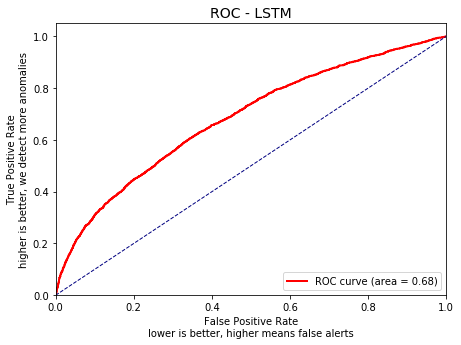

In [176]:
# ROC curve LSTM

fprFg, tprFg, _ = roc_curve(yyy_test[0:yyy_test.size - conf.l_s - conf.n_predictions], lstmscore)
roc_aucFg = auc(fprFg, tprFg)

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.plot(fprFg, tprFg, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_aucFg)
ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate\nlower is better, higher means false alerts')
plt.ylabel('True Positive Rate\nhigher is better, we detect more anomalies')
plt.title('ROC - LSTM', fontsize=14)
plt.legend(loc="lower right")
plt.show()


In [114]:
# Now run gradient boosting - using lightGBM

X_train = df_input[['accel_speed','accel_power_0','accel_power_1','accel_power_2',
                    'accel_power_3','accel_power_4']].to_numpy()
y_train = df_input['vibrations'].to_numpy()

In [34]:
import lightgbm
gbr = lightgbm.LGBMRegressor(n_estimators=4000, learning_rate=0.000001, num_leaves=40,
                           max_depth=20, random_state=42, loss='huber').fit(X_train, y_train)


In [35]:

pred_good = gbr.predict(X_train)
rmse = metrics.mean_squared_error(y_train, pred_good)
gbscoreg = np.abs(pred_good - y_train)
print (rmse)

0.001106535670881264


In [36]:
X_bad = df_inputb[['accel_speed','accel_power_0','accel_power_1','accel_power_2',
                   'accel_power_3','accel_power_4']].to_numpy()
y_bad = df_inputb['vibrations'].to_numpy()
pred_bad = gbr.predict(X_bad) 
rmseb = metrics.mean_squared_error(y_bad, pred_bad)
gbscore = np.abs(pred_bad - y_bad)
print (rmseb)

0.009797515412096496


Text(0.5, 1.0, 'Good Case - no anomalous deviation from prediction')

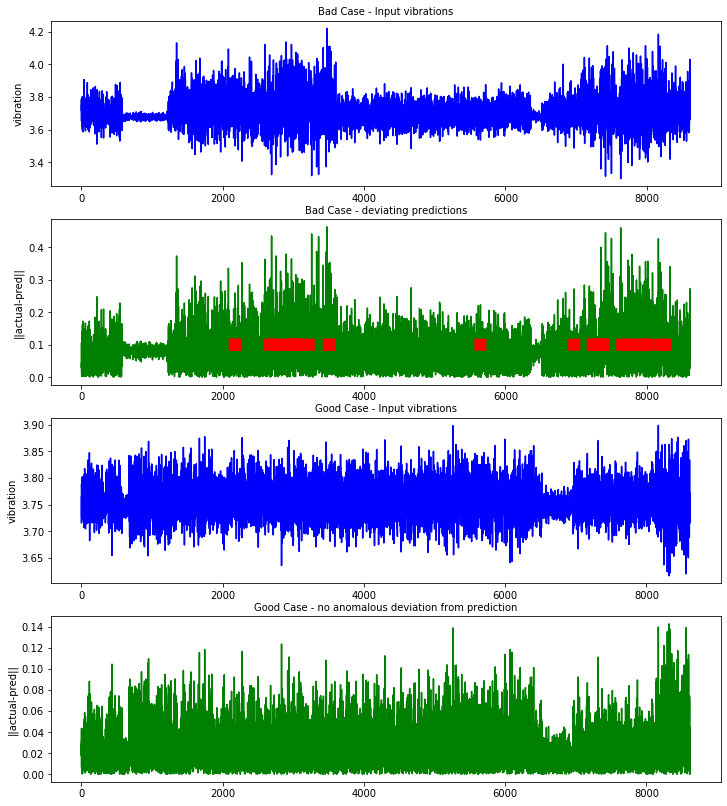

In [37]:
separator = 0.2
anomalygb = gbscore.copy() #(gbscore > separator) # * (separator + 0.1)
anomalygb[anomalygb <= separator] = 0
anomalygb[anomalygb > separator] = separator/2
anomalygb[anomalygb == 0] = np.nan
anomalygg = gbscoreg.copy()
anomalygg[anomalygg <= separator] = 0
anomalygg[anomalygg > separator] = separator/2
anomalygg[anomalygg == 0] = np.nan

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(12,14)) 
ax1.plot(y_bad, color='blue')
ax1.set_title('Bad Case - Input vibrations', fontsize=10)
ax1.set_ylabel('vibration')
ax2.plot(gbscore, color='green')
ax2.plot(anomalygb, color='red', lw=12, zorder=10)
ax2.set_ylabel('||actual-pred||')
ax2.set_title('Bad Case - deviating predictions', fontsize=10)
ax3.plot(y_train, color='blue')
ax3.set_ylabel('vibration')
ax3.set_title('Good Case - Input vibrations', fontsize=10)
ax4.plot(gbscoreg, color='green')
ax4.plot(anomalygg, color='red', lw=12, zorder=10)
ax4.set_ylabel('||actual-pred||')
ax4.set_title('Good Case - no anomalous deviation from prediction', fontsize=10)



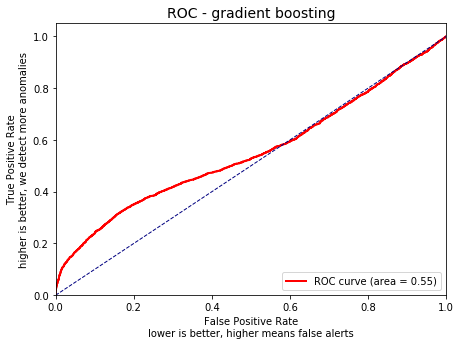

In [56]:
# ROC curve Gradient Boosting

fprFg, tprFg, _ = roc_curve(yyy_test, gbscore)
roc_aucFg = auc(fprFg, tprFg)

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.plot(fprFg, tprFg, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_aucFg)
ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate\nlower is better, higher means false alerts')
plt.ylabel('True Positive Rate\nhigher is better, we detect more anomalies')
plt.title('ROC - gradient boosting', fontsize=14)
plt.legend(loc="lower right")
plt.show()


#### Results

Gradient boosting appeared to do much better until Shradda fixed the ROC curve plot.

Now I understand (and accept) why I had to explicitly disable the r2_score check in the pipeline's GBMRegressor to enforce saving the model to Cloud Object Store.

Training time is much shorter compared to the NASA model, but there is a price


In [39]:
from sklearn.metrics import r2_score

'''
Coefficent of determinatoin: the proportion of the variance in the dependent variable 
that is predictable from the independent variable(s). It provides a measure of how well 
observed outcomes are replicated by the model, based on the proportion of total variation 
of outcomes explained by the model
Best posible score = 1.0
Values of r2 outside 0-1: model fits data worse than a horizontal hyperplane
'''

print('R_sq/Test Variance score:' + str(r2_score(y_bad, pred_bad)))

R_sq/Test Variance score:-0.25058676111247435


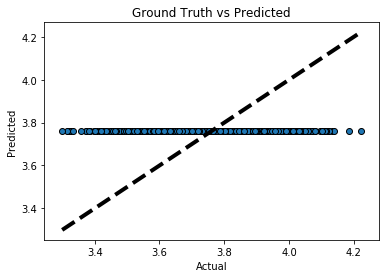

In [40]:
from sklearn.model_selection import cross_val_predict

fig, ax = plt.subplots()
ax.scatter(y_bad, pred_bad, edgecolors=(0, 0, 0))
ax.plot([y_bad.min(), y_bad.max()], [y_bad.min(), y_bad.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Ground Truth vs Predicted")
plt.show()